Instructions:

https://docs.google.com/document/d/1EUrcRXN7OWYpOvrb8mcUJYZn1vdR63MoLpuFz8ep10I/edit?usp=sharing

תרגיל - ניתוח טקסט - סיווג סנטימנט

מטרת התרגיל היא לסווג סנטימנט שלילי/חיובי מתוך תגובות בדף הפייסבוק של הנשיא ריבלין.
ראשית, יש להיכנס לקישור הבא:
https://github.com/omilab/Neural-Sentiment-Analyzer-for-Modern-Hebrew
בקישור הנ״ל אפשר למצוא שני jupyter notebooks שבשלב זה לא רלוונטיים, אפשר להתעלם מהן. מה שכן נדרש שקריאת ההסבר בקובץ readme וקריאת המאמר עצמו. 
לאחר השלמת החלק התיאורטי, נדרש לכתוב מסווג פשוט המבוסס על TF-IDF אך לא רק ואפשר להשתמש ברעיונות נוספים כמו למשל POS. הרעיון, לממש מסווג פשוט ולא רשתות עמוקות, למשל אפשר להשתמש ב-Logistic Regression Classifier.


References
Introduction to Information Retrieval
Tf-idf weighting
How to Use Tfidftransformer & Tfidfvectorizer - A Short Tutorial
sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.24.2 documentation


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from nltk.tokenize import TreebankWordTokenizer

from keras.utils.np_utils import to_categorical
import emoji
import re
import string
import json
import codecs
import pandas as pd
import os
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import operator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering

# Loading the data

In [4]:
def load_data(filename):
    data = list(codecs.open(filename, 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    # Reducing any char-acter sequence of more than 3 consecutive repetitions to a respective 3-character sequence 
    # (e.g. “!!!!!!!!”turns to “!!!”)
    # x = [re.sub(r'((.)\2{3,})', r'\2\2\2', i) for i in x]
    x = np.asarray(list(x))
    y = np.array(y).astype(np.int)
    #y = to_categorical(y, 3)
    
    
    return x, y

In [5]:
x_token_train, y_token_train = load_data('data/token_train.tsv')
x_token_test, y_token_test = load_data('data/token_test.tsv')
x_morph_train, y_morph_train = load_data('data/morph_train.tsv')
x_morph_test, y_morph_test = load_data('data/morph_test.tsv')


In [6]:
# putting in dataframe

train_df = pd.DataFrame()
train_df["x_token_train"] = x_token_train
train_df["y_token_train"] = y_token_train
train_df["x_morph_train"] = x_morph_train
train_df["y_morph_train"] = y_morph_train

test_df = pd.DataFrame()
test_df["x_token_test"] = x_token_test
test_df["y_token_test"] = y_token_test
test_df["x_morph_test"] = x_morph_test
test_df["y_morph_test"] = y_morph_test


# EDA

## train_df

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   x_token_train  10244 non-null  object
 1   y_token_train  10244 non-null  int32 
 2   x_morph_train  10244 non-null  object
 3   y_morph_train  10244 non-null  int32 
dtypes: int32(2), object(2)
memory usage: 240.2+ KB


In [8]:
train_df.describe()

,y_token_train,y_morph_train
count,10244.00000,10244.00000
mean,0.36392,0.36392
std,0.53823,0.53823
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,1.00000,1.00000
max,2.00000,2.00000


<AxesSubplot:ylabel='y_token_train'>

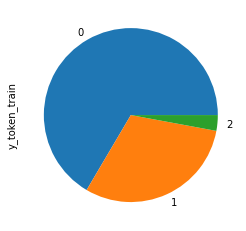

In [9]:
train_df.y_token_train.value_counts().plot(kind ='pie')

In [10]:
train_df.corr()

,y_token_train,y_morph_train
y_token_train,1.0,1.0
y_morph_train,1.0,1.0


In [11]:
train_df[train_df.y_token_train == 0][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,0
1,איש יקר שלנו,0,איש יקר של אנחנו,0
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,0


In [12]:
train_df[train_df.y_token_train == 1][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
9,אדוני הנשיא סליחה על הבוטות תפסיק לזיין את השכ...,1,אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה...,1
11,ואני עוד חשבתי שהגיע נשיא נורמלי,1,ו אני עוד חשבתי ש הגיע נשיא נורמלי,1
12,נשיא המדינה הלבן והמנותק חכם בדיבורים . הוא לא...,1,נשיא ה מדינה ה לבן ו ה מנותק חכם ב ה דיבורים ....,1
14,""" רובי ריבלין היקר !! אתה איש משפחה לא ???.. מ...",1,""" רובי ריבלין ה יקר !! אתה איש משפחה לא ???.. ...",1
18,עוד לא שבוע בתפקיד וכבר שכחת מאיפה באת ?,1,עוד לא שבוע ב ה תפקיד ו כבר שכחת מ איפה באת ?,1


In [13]:
train_df[train_df.y_token_train == 2][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
53,חייבים לעשות סוג של חרם כשכתבים שונאי ישראל עו...,2,חייבים לעשות סוג של חרם כש כתבים שונאי ישראל ע...,2
78,אז אתה בא ? https://www.facebook.com/events/15...,2,אז אתה בא ? https://www.facebook.com/events/15...,2
82,""" גאי אתה טיפש מטופש ילד כאפות שלא חונך על ברכ...",2,""" גאי אתה טיפש מטופש ילד כאפות ש לא חונך על בר...",2
117,שמעון יפרח העלאתי בשבילך את דבריו של שמעון פרס...,2,ש מעון יפרח העלאתי בשביל אתה את דבריו של שמעון...,2
181,רובי ריבלין הנשיא העשירי תחזית שניתנה לפני הבח...,2,רובי ריבלין ה נשיא ה עשירי תחזית ש ניתנה לפני ...,2


The dataset contains:
1. **x_token_train** - collection of talkback as strings
2. **y_token_train** - Sentiment classification (target), (0 - Positive, 1 - Negative, 2 - Neutral)
3. **x_morph_train** - same as x_token_train, but seperated to prefix, nuclear word, suffix (morphologically rich language)
4. **y_morph_train** - same as y_token_train, since it is the same sentiment

morph examples:    

    לנשיאות
    ל ה נשיאות

    לה הצלחה
    ל היא הצלחה

In [14]:
# dropping the duplicate y_morph_train column

In [15]:
train_df.drop('y_morph_train', axis='columns', inplace=True)
train_df.rename(columns={"y_token_train": "y_train"}, inplace=True)

In [16]:
train_df.head()

,x_token_train,y_train,x_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...
1,איש יקר שלנו,0,איש יקר של אנחנו
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ..."
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .


In [17]:
# Cleaning methods:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def keep_only_heb(p_text):
    CHARS_PATTERN = re.compile(r"""[^אבגדהוזחטיכלמנסעפצקרשתןףץםך'\- "]""")
    return CHARS_PATTERN.sub('', p_text)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [23]:
# adding a clean token column
stop_words =[]
with open('hebrew_stop_words.json', 'r', encoding="utf8") as f:
    stop_words = json.load(f)
    
# use get_display to convert the hebrew stop words, so the word cloud won't be reversed 
bd_hsw = get_display(" ".join(stop_words)).split(" ")

train_df["clean_token"] = train_df.x_token_train.map(lambda x: keep_only_heb(x))
train_df["clean_token"] = train_df.clean_token.map(lambda x: remove_URL(x))
train_df["clean_token"] = train_df.clean_token.map(lambda x: remove_html(x))
train_df["clean_token"] = train_df.clean_token.map(lambda x: remove_emoji(x))
train_df["clean_token"] = train_df.clean_token.map(lambda x: remove_punct(x))
train_df["clean_token"] = train_df.clean_token.map(lambda x: remove_stopwords(x))
train_df["len_clean"] = train_df.clean_token.map(lambda x: len((x)))

## wordcloud

In [27]:
train_df.len_clean.value_counts() < 10

18      False
13      False
14      False
15      False
8       False
        ...  
580      True
676      True
908      True
1236     True
1967     True
Name: len_clean, Length: 534, dtype: bool

In [31]:
train_df = train_df[train_df.len_clean > 10]

In [32]:
train_df.head()

,x_token_train,y_train,x_morph_train,clean_token,len_clean
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,ממש כואב בוכה המשפחה שלא תדעו עוד צער,37
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,הכבוד והמון בהצלחה,18
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",תל חי רובי בכל העצב הזה היית קרן אור תקוה אכן ...,57
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,נקי כפיים ובר לבב בהצלחה לך ולנו,32
5,רובי חג שמח והצלחה בבחירות לנשיאות .,0,רובי חג שמח ו הצלחה ב בחירות ל ה נשיאות .,רובי חג שמח והצלחה בבחירות לנשיאות,34


In [19]:
# displaying a word cloud of the diffrent sentiment

In [20]:
from wordcloud import WordCloud



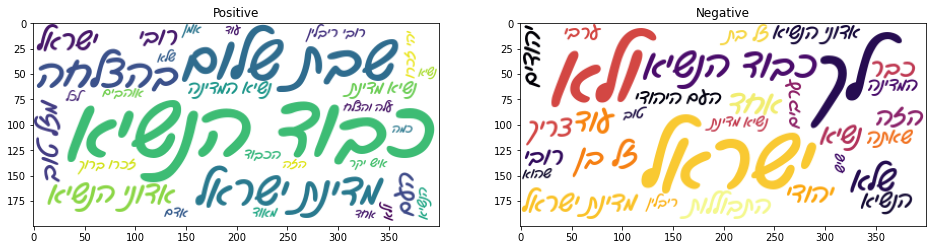

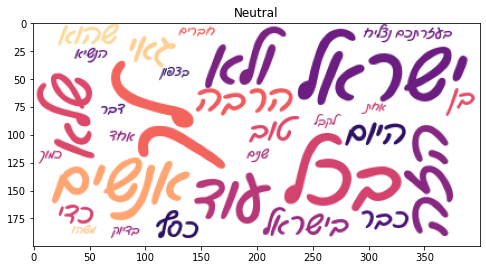

In [33]:
all_positive_wc = WordCloud(
    colormap='viridis',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(train_df[train_df.y_train==0].clean_token)))

all_negative_wc = WordCloud(
    colormap='inferno',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(train_df[train_df.y_train==1].clean_token)))

all_neutral_wc = WordCloud(
    colormap='magma',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(train_df[train_df.y_train==2].clean_token)))

plt.figure(1, figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("Positive")
plt.imshow(all_positive_wc)

plt.subplot(1, 2, 2)
plt.title("Negative")
plt.imshow(all_negative_wc)

plt.figure(2, figsize=(8, 8))
plt.title("Neutral")
plt.imshow(all_neutral_wc)



# TF IDF & Logistic Regression

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [37]:
def tfidf(train_words, train_target, test_words, test_target):
    tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 1))
    document_term_matrix = tfidf_vectorizer.fit_transform(train_words)
    
    feature_names = tfidf_vectorizer.get_feature_names()
    print(feature_names)
    
    # Training the model

    X = document_term_matrix
    y = train_target

    X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(class_weight="balanced")
    model.fit(X_train_tfidf, y_train_tfidf)

    y_pred = model.predict(X_test)

    f1score = f1_score(y_test, y_pred, average='weighted')
    print(f"Tfidf training Model Score: {f1score * 100} %")
    
    # return tfidf_vectorizer
    
    # Testing the model
    test_tfidf = tfidf_vectorizer.transform(test_words)
    y_test_predict =model.predict(test_tfidf)
    
    f1score = f1_score(y_test_predict, test_target, average='weighted')
    print(f"Tfidf Test Model Score: {f1score * 100} %")
    
   # cm = confusion_matrix(test_target, y_test_predict)
    
    #print(cm)
    #sn.heatmap(cm, annot=True)

## Token

In [38]:
tfidf(train_df.clean_token, train_df.y_train, test_df.x_token_test, test_df.y_token_test)

['אא', 'אאא', 'אאאאאאאאאאאא', 'אאחחחח', 'אאחל', 'אאלץ', 'אאמין', 'אב', 'אבא', 'אבאי', 'אבבה', 'אבד', 'אבדות', 'אבדתי', 'אבו', 'אבוא', 'אבוד', 'אבודה', 'אבודים', 'אבומאזן', 'אבוצדקה', 'אבוקסיס', 'אבות', 'אבותאי', 'אבותיו', 'אבותיך', 'אבותיכם', 'אבותינו', 'אבותנו', 'אבטחה', 'אבטל', 'אבי', 'אביאל', 'אביב', 'אביגדור', 'אביגיל', 'אבידה', 'אביה', 'אביהם', 'אביו', 'אביון', 'אביונה', 'אביחי', 'אביחיל', 'אביטל', 'אביטן', 'אביך', 'אבינו', 'אביע', 'אביעד', 'אביצדק', 'אבישי', 'אבישר', 'אביתר', 'אבלות', 'אבלי', 'אבללללל', 'אבן', 'אבני', 'אבניה', 'אבנייה', 'אבנים', 'אבנר', 'אבסורד', 'אבקש', 'אבקשך', 'אבר', 'אבראה', 'אברהם', 'אברהמי', 'אברום', 'אבריו', 'אבריימי', 'אברים', 'אברכך', 'אברכם', 'אברמוב', 'אבשלום', 'אבתיך', 'אג', 'אגב', 'אגג', 'אגד', 'אגדל', 'אגו', 'אגון', 'אגיב', 'אגיד', 'אגן', 'אגנדה', 'אגרוף', 'אגריפס', 'אגרת', 'אדבר', 'אדום', 'אדומה', 'אדומות', 'אדומים', 'אדון', 'אדוןריבלין', 'אדוני', 'אדוניאתה', 'אדוננו', 'אדח', 'אדי', 'אדיוט', 'אדיני', 'אדיר', 'אדירה', 'אדירות', 'אדירים', 'אדיש', 'אד

Tfidf training Model Score: 88.2832166977544 %
Tfidf Test Model Score: 88.46806006281899 %


In [ ]:
train_df.clean_token.sample(50)

## Morph

In [ ]:
tfidf(train_df.x_morph_train, train_df.y_train, test_df.x_morph_test, test_df.y_morph_test)

# Error Analysis

##  1. Find high distinctive words

### 1.a Plot word frequency, wordclouds, connection words that affect the classification

## 2. Perform a naive classification based on the words found

## 3. Explain the confusion matrix

In [ ]:
def print_feature(df, x_column, y_column, print_word, plot_words):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df[x_column])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df[y_column])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(print_word):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(plot_words), sorted_features[:plot_words], rotation=90)
    plt.xlim([-1, plot_words])
    plt.show()

    return()